# Alpha Zero
This project is about developing my own chess AI by using PyTorch and Robert Förster's course on YouTube
(https://www.youtube.com/watch?v=wuSQpLinRB4) which has been a very big help. 

## Importing libraries

In [2]:
import numpy as np
print(np.__version__)

import torch
print(torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)

import matplotlib.pyplot as plt

from tqdm.notebook import trange

import random
import math

1.23.5
2.0.1+cu117


## Create a game

The game must have following  properties / methods: 
- <b>row_count:</b> return the number of rows of the board
- <b>column_count:</b> return the number of columns of the board
- <b>action_size:</b> return the actions which can be taken at the board (TicTacToe: row_count * column_count)  
- <b>get_initial_state():</b> return the board at the beginning of the game
- <b>get_next_state(state, action, player):</b> make a move and update the board
- <b>get_valid_moves(state):</b> return all possible moves at the current state
- <b>check_win(state, action):</b> check if an action at a current state results in a win
- <b>get_value_and_terminated(state, action):</b> check if the game has ended in some way (lose, draw, win)
- <b>get_opponent(player):</b> get the opponent player 
- <b>get_opponent_value(player):</b> get the value of the opponent player 
- <b>change_perspective(state, player):</b> change the perspective of the board (e.g. state * player)
- <b>get_encoded_state(state):</b> return a encoded version of the current state  

In [3]:
class TicTacToe:
    def __init__(self):
        self.row_count = 3
        self.column_count = 3
        self.action_size = self.row_count * self.column_count
        
    def get_initial_state(self):
        return np.zeros((self.row_count, self.column_count))
    
    def get_next_state(self, state, action, player):
        row = action // self.column_count
        column = action % self.column_count
        state[row, column] = player
        return state
    
    def get_valid_moves(self, state):
        return (state.reshape(-1) == 0).astype(np.uint8)
    
    def check_win(self, state, action):
        if action == None:
            return False
        
        row = action // self.column_count
        column = action % self.column_count
        player = state[row, column]
        
        return (
            np.sum(state[row, :]) == player * self.column_count
            or np.sum(state[:, column]) == player * self.row_count
            or np.sum(np.diag(state)) == player * self.row_count
            or np.sum(np.diag(np.flip(state, axis=0))) == player * self.row_count
        )
    
    def get_value_and_terminated(self, state, action):
        if self.check_win(state, action):
            return 1, True # this action ended the game with a win for the player who took this action
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True # this action ended the game but the players drew
        return 0, False # the game has not ended yet
    
    def get_opponent(self, player):
        return -player
    
    def get_opponent_value(self, value):
        return -value
    
    def change_perspective(self, state, player):
        return state * player
    
    def get_encoded_state(self, state):
        encoded_state = np.stack(
            (state == -1, state == 0, state == 1)
        ).astype(np.float32)
        
        return encoded_state

## Designing of a model

Here a ResNet model has been chosen, containing of multiple Conv2D Layers which can find patterns in 2d games like TicTacToe or chess.  
The ResNet has following layers:
- 1 x startblock 
- n x backbone (here the input will be additionally added to the output)
- 1 x policyhead (returns policy values as a linear layer)
- 1 x valuehead (returns value in range -1 and 1 (by using tanh))  

In [4]:
class ResNet(nn.Module):
    def __init__(self, game, num_resBlocks, num_hidden, device):
        super().__init__()
        
        self.device = device
        # combination of kernel_size=3, padding=1 and stride=1 important => guarantees that input_shape = output_shape  
        # e.g.: 5x5 image with 3x3 convolution results in a 3x3 output => padding 1 in all directions results in a 5x5 output
        # therefore the shape of the image stays consistant during the computations
        self.startBlock = nn.Sequential(
            nn.Conv2d(3, num_hidden, kernel_size=3, padding=1), 
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )
        
        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )
        
        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * game.row_count * game.column_count, game.action_size)
        )
        
        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.row_count * game.column_count, 1),
            nn.Tanh()
        )
        
        self.to(device)
        
    def forward(self, x):
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value
        
        
class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)
        
    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x
        

## Updated MCTS Implementation

Using the Monte Carlo Tree Search algorithm enables splitting the game of choice in many different paths of action and their probability of success.  
Therefore it is perfect for solving a game tree in games like chess or TicTacToe.  
It contains of four phases: 
- <u>Selection:</u> Walking down until a leaf node has been found (leaf node is a node that could be expanded even further)  
             The path is determined by the UCB-fomular (a node is chosen which has a higher winning prob and lower visit counts)
- <u>Expansion:</u> When reached a leaf node in the selection phase, new leaf node(s) will be created, which are attached at the current node
- <u>Simulation:</u> Simulate the game by either random choices or like in the updated version, by using a neural network 
- <u>Backpropagation:</u> Update the tree from the bottom to the top (until root node is reached)

In [5]:
class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0, visit_count=0):
        self.game = game
        self.args = args
        self.state = state # current state of the game
        self.parent = parent # the parent node
        self.action_taken = action_taken # the action which has to be taken to arrive at this node 
        self.prior = prior # is the policy value the model provided us 
        
        self.children = [] # list of all child nodes
        
        self.visit_count = visit_count # the count of all visits to this node
        self.value_sum = 0 # the current sum of all simulations (of the neural network)
    
    # check if current node has child nodes
    def is_fully_expanded(self):
        return len(self.children) > 0
    
    # returns the child node with the highest ucb score during selection phase
    def select(self):
        best_child = None
        best_ucb = -np.inf
        
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
                
        return best_child
    
    # calculate the ucb value of a child node
    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            # 1 - ()  because we want to have the opponent in the worst possible situation in the next move
            # ( +1) / 2 because we want a proablilty and not some negative values which could occur in this implementation
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior
    
    # expanding the tree in all possible directions (all valid moves own a child node)
    def expand(self, policy):
        for action, prob in enumerate(policy):
            if prob > 0:
                child_state = self.state.copy()
                # we are always player 1 - we just change the states 
                child_state = self.game.get_next_state(child_state, action, 1)
                child_state = self.game.change_perspective(child_state, player=-1)

                child = Node(self.game, self.args, child_state, self, action, prob)
                self.children.append(child)

    # update the whole tree (all parant nodes beginning from current node)
    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1
        
        value = self.game.get_opponent_value(value)
        if self.parent is not None:
            self.parent.backpropagate(value)  


class MCTS:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model

    # this is the above explained sequence the mcts algorithm has to follow  
    @torch.no_grad() # not updating the gradiants when calling this function => no training or updating the model here 
    def search(self, state):
        root = Node(self.game, self.args, state, visit_count=1)
        
        policy, _ = self.model(
            torch.tensor(self.game.get_encoded_state(state), device=self.model.device).unsqueeze(0)
        )
        policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
        policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] \
            * np.random.dirichlet([self.args['dirichlet_alpha']] * self.game.action_size)
        
        # deleting invalid moves and renormalizing before expanding
        valid_moves = self.game.get_valid_moves(state)
        policy *= valid_moves
        policy /= np.sum(policy)
        root.expand(policy)
        
        for search in range(self.args['num_searches']):
            node = root
            
            # run until leaf node is found
            while node.is_fully_expanded():
                node = node.select()
                
            value, is_terminated = self.game.get_value_and_terminated(node.state, node.action_taken)
            # action_taken is here the action taken by the opponent => if value says we won -> opponent won
            value = self.game.get_opponent_value(value)
            
            if not is_terminated:
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state), device=self.model.device).unsqueeze(0)
                )
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                valid_moves = self.game.get_valid_moves(node.state)
                policy *= valid_moves
                policy /= np.sum(policy)
                
                value = value.item()
                
                node.expand(policy)
                
            node.backpropagate(value)    
            
        # get the most promising child out of all root children
        # => the child with the most visit_counts is the most promising 
        # because of how the ucb-formular works
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs

## AlphaZero Implementation
The AlphaZero algorithm works by looping following sequence n times: 
- let the engine play itsself by using the updated MTCS algorithm -> collecting training data
- update the engine by its generated training data

In [6]:
class AlphaZero:
    def __init__(self, model, optimizer, game, args):
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTS(game, args, model)
    
    # one playthrough the game of choice
    # returns a list containing: 
    #   - A encoded state of all states  
    #   - the action probabilities to the correspondending states
    #   - the player who won (1 or -1 -> starting player is 1)
    def selfPlay(self):
        memory = []
        player = 1
        state = self.game.get_initial_state()
        
        while True:
            # change perspective of game field (has no effect in the first loop)
            neutral_state = self.game.change_perspective(state, player)
            # get the probabilities of all valid moves with the mcts algorithm
            action_probs = self.mcts.search(neutral_state) 
            # append current state and move probs to the memory of this game for later training
            memory.append((neutral_state, action_probs, player))
            
            temperature_action_probs = action_probs ** (1 / self.args['temperature'])
            # choose one move which has big probability of success
            action = np.random.choice(self.game.action_size, p=temperature_action_probs)
            # make move on board
            state = self.game.get_next_state(state, action, player)
            # check if game has ended and if player has won
            value, is_terminated = self.game.get_value_and_terminated(state, action)
            
            # if playthrough is finished
            if is_terminated:
                returnMemory = [] # format the memory which will be used as training data
                for hist_neutral_state, hist_action_probs, hist_player in memory:
                    # value is always 1 if somebody won -> it must be -1 if opponent won 
                    hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                    returnMemory.append((
                        self.game.get_encoded_state(hist_neutral_state),
                        hist_action_probs,
                        hist_outcome
                    ))
                return returnMemory
            
            player = self.game.get_opponent(player) # switch player for next walkthrough
                
    # the training algorithm of the neural network 
    # the training data (memory) will be generated by the selfplay method
    def train(self, memory):
        random.shuffle(memory) # the memory is shuffled to prevent momorising 
        for batchIdx in range(0, len(memory), self.args['batch_size']):
            sample = memory[batchIdx:min(len(memory) - 1, batchIdx + self.args['batch_size'])]
            state, policy_targets, value_targets = zip(*sample)
            
            state, policy_targets, value_targets = np.array(state), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)
            
            # make tensors for neural network
            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)
            
            # run encoded state through the model
            out_policy, out_value = self.model(state)
            
            # run loss functions 
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss
            
            # run optimizer 
            self.optimizer.zero_grad() 
            # backpropagate
            loss.backward()
            self.optimizer.step() 
    
    # the main loop where the training and the selfplay is initialized
    def learn(self):
        for iteration in range(self.args['num_iterations']):
            memory = []
            
            self.model.eval() # set the model to eval mode
            for selfPlay_iteration in trange(self.args['num_selfPlay_iterations']):
                memory += self.selfPlay()
                
            self.model.train() # set the model to train mode
            for epoch in trange(self.args['num_epochs']):
                self.train(memory)
            
            torch.save(self.model.state_dict(), f"model_{iteration}.pt")
            torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}.pt")

## Training the model

In [ ]:
tictactoe = TicTacToe()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(tictactoe, 4, 64, device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

args = {
    'C': 2,
    'num_searches': 60,
    'num_iterations': 3,
    'num_selfPlay_iterations': 500,
    'num_epochs': 4,
    'batch_size': 64,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
}

alphaZero = AlphaZero(model, optimizer, tictactoe, args)
alphaZero.learn()

## Testing the model

0.939461886882782
[[ 0.  0. -1.]
 [ 0. -1.  0.]
 [ 1.  0.  1.]]
tensor([[[[0., 0., 1.],
          [0., 1., 0.],
          [0., 0., 0.]],

         [[1., 1., 0.],
          [1., 0., 1.],
          [0., 1., 0.]],

         [[0., 0., 0.],
          [0., 0., 0.],
          [1., 0., 1.]]]], device='cuda:0')


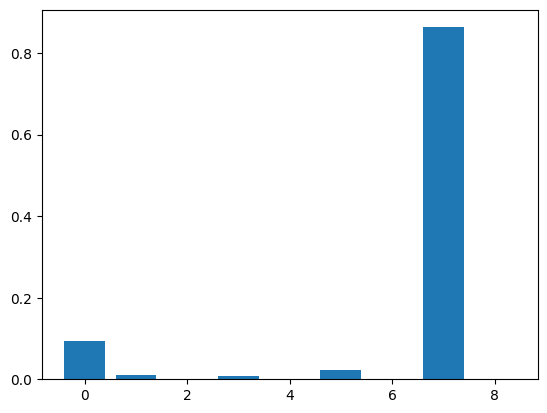

In [7]:
tictactoe = TicTacToe()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state = tictactoe.get_initial_state()
state = tictactoe.get_next_state(state, 2, -1)
state = tictactoe.get_next_state(state, 4, -1)
state = tictactoe.get_next_state(state, 6, 1)
state = tictactoe.get_next_state(state, 8, 1)


encoded_state = tictactoe.get_encoded_state(state)

tensor_state = torch.tensor(encoded_state, device=device).unsqueeze(0)

model = ResNet(tictactoe, 4, 64, device=device)
model.load_state_dict(torch.load('model_2.pt', map_location=device))
model.eval()

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

print(value)

print(state)
print(tensor_state)

plt.bar(range(tictactoe.action_size), policy)
plt.show()

In [8]:
tictactoe = TicTacToe()
player = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

args = {
    'C': 2,
    'num_searches': 1000,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3

}

model = ResNet(tictactoe, 4, 64, device)
model.eval()

mcts = MCTS(tictactoe, args, model)

state = tictactoe.get_initial_state()


while True:
    print(state)
    
    if player == 1:
        valid_moves = tictactoe.get_valid_moves(state)
        print("valid_moves", [i for i in range(tictactoe.action_size) if valid_moves[i] == 1])
        action = int(input(f"{player}:"))

        if valid_moves[action] == 0:
            print("action not valid")
            continue
            
    else:
        neutral_state = tictactoe.change_perspective(state, player)
        mcts_probs = mcts.search(neutral_state)
        action = np.argmax(mcts_probs)
        
    state = tictactoe.get_next_state(state, action, player)
    
    value, is_terminal = tictactoe.get_value_and_terminated(state, action)
    
    if is_terminal:
        print(state)
        if value == 1:
            print(player, "won")
        else:
            print("draw")
        break
        
    player = tictactoe.get_opponent(player)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
valid_moves [0, 1, 2, 3, 4, 5, 6, 7, 8]


[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
probs:  [0.    0.07  0.098 0.088 0.179 0.125 0.223 0.067 0.15 ]
[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [-1.  0.  0.]]
valid_moves [1, 2, 3, 4, 5, 7, 8]


ValueError: invalid literal for int() with base 10: ''